## Import modules, packages and libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, zero_one_loss, precision_score, recall_score
from sklearn.neural_network import MLPClassifier

## Read cleaned data and split into features and targets

In [29]:
df = pd.read_csv("../data/cleaned_data.csv")

numerical_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numerical_cols.remove("loan_status")

scaler = StandardScaler()
scaler.fit(df[numerical_cols])
df[numerical_cols] = scaler.transform(df[numerical_cols])

feature_names = ['small_business', 'int_rate', 'term', 'dti', 'MORTGAGE', 'Not Verified', 'avg_cur_bal',
                 'acc_open_past_24mths', 'fico_range_avg', 'mort_acc']
features = df[feature_names]
targets = df["loan_status"]
features

,small_business,int_rate,term,dti,MORTGAGE,Not Verified,avg_cur_bal,acc_open_past_24mths,fico_range_avg,mort_acc
0,-0.105789,-0.313537,-0.514225,1.064830,-0.973265,1.577822,-0.471799,-0.601582,-0.008344,-0.842549
1,-0.105789,0.833317,-0.514225,0.702465,-0.973265,-0.633785,-0.652458,0.579975,-0.639529,-0.842549
2,-0.105789,-1.305626,-0.514225,-0.239883,1.027470,1.577822,2.269429,-0.896971,0.780637,-0.311722
3,-0.105789,0.119013,1.944673,0.062417,1.027470,-0.633785,-0.569264,1.170753,-1.112917,-0.311722
4,-0.105789,-1.127050,-0.514225,-0.700717,-0.973265,-0.633785,-0.611390,-1.192361,-0.166140,-0.842549
...,...,...,...,...,...,...,...,...,...,...
145016,-0.105789,-0.333379,-0.514225,-0.003557,-0.973265,1.577822,-0.442260,-0.601582,-0.481733,-0.842549
145017,-0.105789,-0.313537,-0.514225,0.161870,-0.973265,-0.633785,-0.442821,-1.487750,-1.112917,-0.842549
145018,-0.105789,-0.317506,-0.514225,-1.281683,-0.973265,-0.633785,-0.717704,1.170753,-0.797325,-0.311722
145019,-0.105789,1.670639,1.944673,-0.481131,1.027470,-0.633785,0.992603,1.466143,-0.639529,0.219105


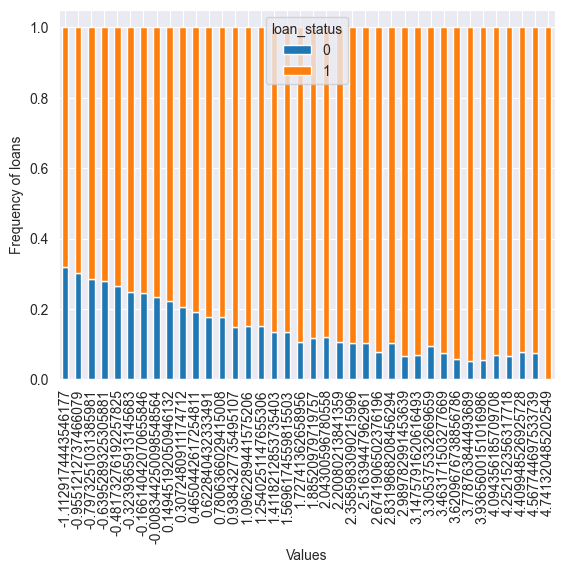

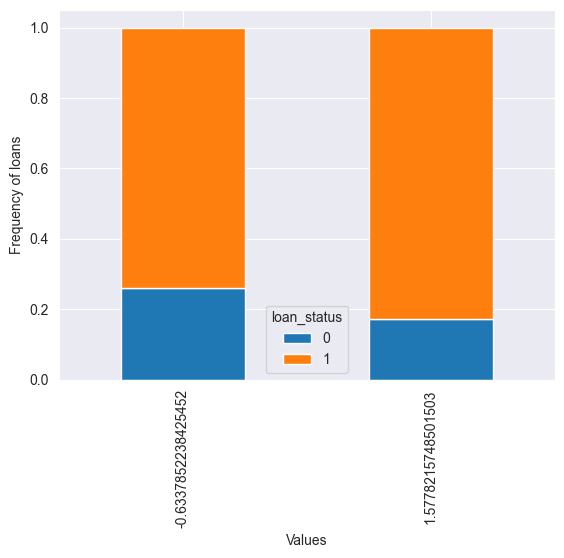

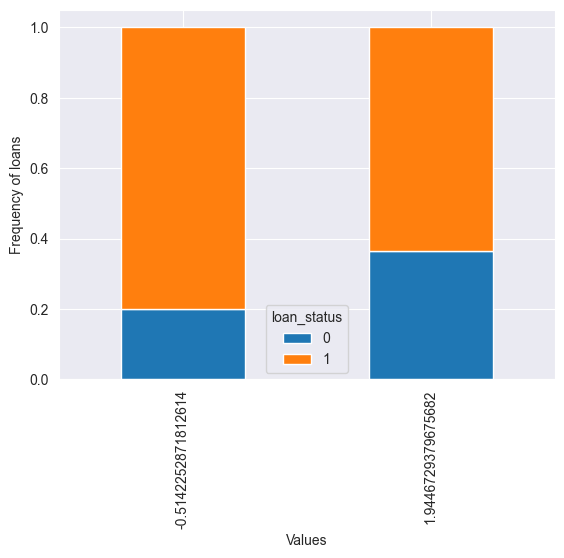

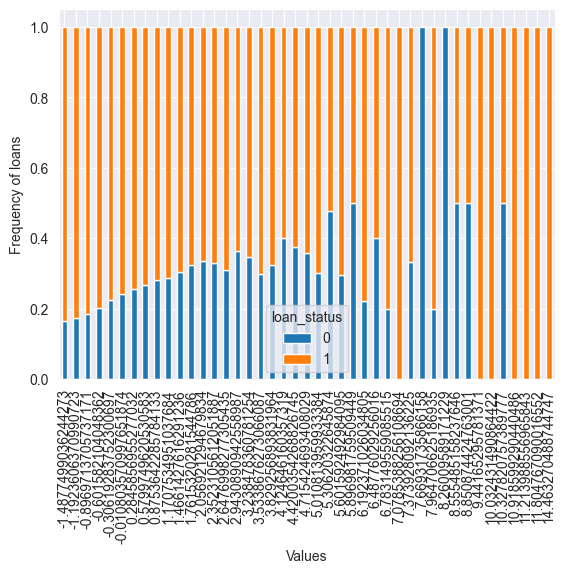

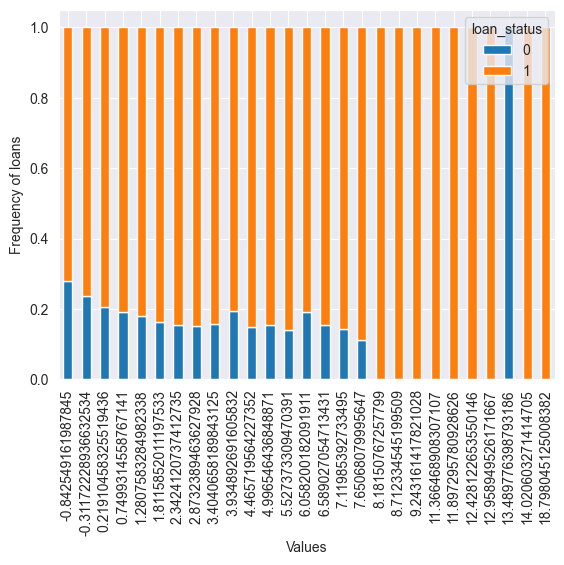

In [30]:
counts = df.groupby(['fico_range_avg'])['loan_status'].value_counts().unstack()
frequencies = counts.div(counts.sum(axis=1), axis=0)
frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Values')
plt.ylabel('Frequency of loans')
plt.show()

counts = df.groupby(['Not Verified'])['loan_status'].value_counts().unstack()
frequencies = counts.div(counts.sum(axis=1), axis=0)
frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Values')
plt.ylabel('Frequency of loans')
plt.show()

counts = df.groupby(['term'])['loan_status'].value_counts().unstack()
frequencies = counts.div(counts.sum(axis=1), axis=0)
frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Values')
plt.ylabel('Frequency of loans')
plt.show()

counts = df.groupby(['acc_open_past_24mths'])['loan_status'].value_counts().unstack()
frequencies = counts.div(counts.sum(axis=1), axis=0)
frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Values')
plt.ylabel('Frequency of loans')
plt.show()

counts = df.groupby(['mort_acc'])['loan_status'].value_counts().unstack()
frequencies = counts.div(counts.sum(axis=1), axis=0)
frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Values')
plt.ylabel('Frequency of loans')
plt.show()

# Setup and training a single hidden layer neural network

In [31]:
# helper functions
def map_probabilities(y_pred, threshold=0.5):
    predictions = []
    for y in y_pred:
        if y >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [32]:
# Activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Derivative of the activation function
def derivative_sigmoid(z):
    fz = sigmoid(z)
    return fz * (1 - fz)


# MSE
def loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


class NeuralNetwork:
    def __init__(self,
                 size_input,
                 size_hidden=35,
                 learning_rate=0.1,
                 n_epochs=50,
                 batch_size=10000,
                 early_stop=5,
                 epsilon=0.0025):
        # generate random weights and biases
        self.w1 = np.random.randn(size_input, size_hidden)
        self.b1 = np.random.randn(size_hidden)
        self.w2 = np.random.randn(size_hidden, 1)
        self.b2 = np.random.randn()
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stop = early_stop
        self.epsilon = epsilon
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

    def forward_pass(self, x):
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(self.z2)

        return self.a2

    def backpropagation(self, x, y):
        n = len(x)
        a2_change = (y - map_probabilities(self.a2)).reshape(len(y), 1) * derivative_sigmoid(self.z2)
        a1_change = np.dot(a2_change, self.w2.T) * derivative_sigmoid(self.z1)

        self.w2 += self.learning_rate * np.dot(self.a1.T, a2_change) / n
        self.w1 += self.learning_rate * np.dot(x.T, a1_change) / n
        self.b2 += self.learning_rate * a2_change.mean(axis=0) / n
        self.b1 += self.learning_rate * a1_change.mean(axis=0) / n

    def fit(self, x, y, x_val, y_val):
        accuracies = []
        no_change_epochs = 0

        for epoch in range(self.n_epochs):
            for i in range(0, len(x), self.batch_size):
                input = x[i: i + self.batch_size]
                targets = y[i: i + self.batch_size]

                self.forward_pass(input)
                self.backpropagation(input, targets)

            accuracy = 1 - zero_one_loss(y_validation, map_probabilities(self.predict(x_val)))
            accuracies.append(accuracy)
            if epoch > 0 and accuracies[epoch] - accuracies[epoch - 1] < self.epsilon:
                no_change_epochs += 1
            else:
                no_change_epochs = 0

            if no_change_epochs >= self.early_stop:
                break
        return accuracies

    def predict(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, self.w2) + self.b2
        a2 = sigmoid(z2)
        return a2

In [33]:
size_input = len(feature_names)
size_hidden = 35
n_epochs = 50
learning_rate = 0.1
batch_size = 10000
early_stop = 5
epsilon = 0.0025

x_train, x_test, y_train, y_test = train_test_split(features.values, targets.values, test_size=0.2)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5)

Accuracy: 0.5351306626215265


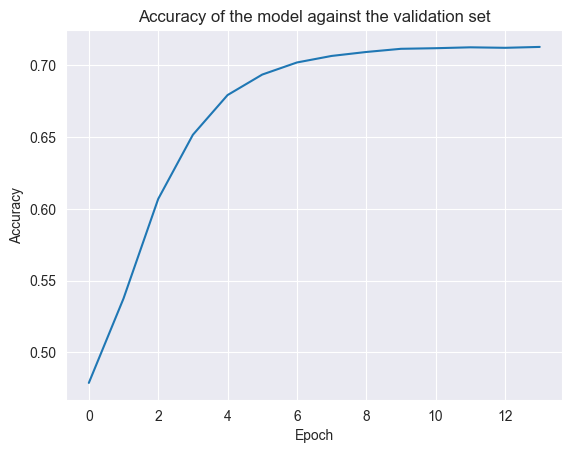

AUC: 0.6487357337108597
Confusion matrix:
[[17.83768875  6.04702475]
 [40.43990898 35.67537751]]
Precision: 0.8550652784663691
True positive rate (TPR): 0.46870187516985234


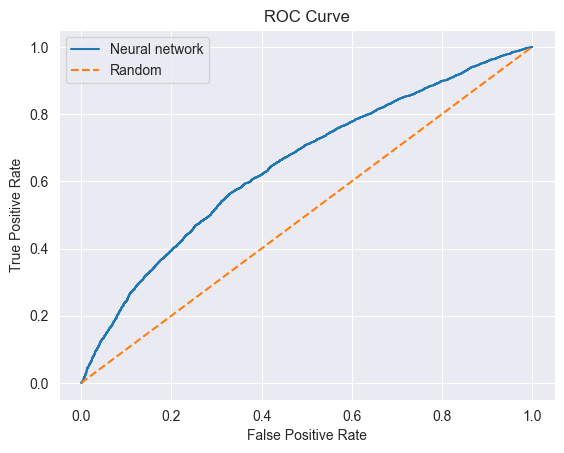

In [36]:
model = NeuralNetwork(
    size_input=size_input,
    size_hidden=size_hidden,
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    batch_size=batch_size,
    early_stop=early_stop,
    epsilon=epsilon
)
accuracies = model.fit(x_train, y_train, x_validation, y_validation)
probabilities = model.predict(x_test)
predictions = map_probabilities(probabilities, 0.8)
print(f"Accuracy: {1 - zero_one_loss(y_test, predictions)}")

plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model against the validation set')
plt.show()

conf_matrix = (confusion_matrix(y_test, predictions) / len(y_test)) * 100
fp, tp, _ = roc_curve(y_test, probabilities)
auc = roc_auc_score(y_test, probabilities)
precision = precision_score(y_test, predictions)
tpr = recall_score(y_test, predictions)
print("AUC:", auc)
print("Confusion matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"True positive rate (TPR): {tpr}")

plt.plot(fp, tp, label='Neural network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Accuracy: 0.6059435978763015
AUC: 0.7140364929129077
Confusion matrix:
[[17.73426188  6.15045163]
 [33.25518858 42.86009791]]
Precision: 0.8745075970737197
True positive rate (TPR): 0.5630944831959417


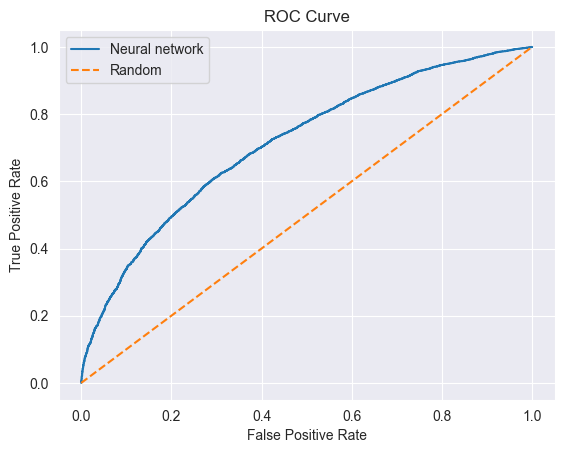

In [35]:
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(15,), (25,), (35,), (45,), (25, 10)],
              'learning_rate': ['constant', 'adaptive'],
              'learning_rate_init': [0.01, 0.1, 0.25],
              'batch_size': [6000, 10000, 12000]
              }
##################################
# TAKES 1 HOUR (RUN ON OWN RISK) #
##################################
# nn = MLPClassifier(
#     max_iter=50,
#     early_stopping=True,
#     n_iter_no_change=5
# )
# grid_search = GridSearchCV(nn, param_grid, cv=5)
# grid_search.fit(x_train, y_train)
# print(grid_search.best_params_)
# OUTPUT:
# {'activation': 'relu', 'batch_size': 6000, 'hidden_layer_sizes': (45,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01} #

model = MLPClassifier(
    hidden_layer_sizes=(45,),  # grid_search.best_params_['hidden_layer_sizes'],
    activation='relu',  # grid_search.best_params_['activation'],
    learning_rate='adaptive',  # grid_search.best_params_['learning_rate'],
    learning_rate_init=0.01,  # grid_search.best_params_['learning_rate_init'],
    batch_size=6000,  # grid_search.best_params_['batch_size'],
    max_iter=n_epochs,
    early_stopping=True,
    n_iter_no_change=5
)
model.fit(x_train, y_train)
probabilities = np.array(list(map(lambda el: el[1], model.predict_proba(x_test))))
predictions = map_probabilities(probabilities, threshold=0.8)
print(f"Accuracy: {1 - zero_one_loss(y_test, predictions)}")

conf_matrix = (confusion_matrix(y_test, predictions) / len(y_test)) * 100
fp, tp, _ = roc_curve(y_test, probabilities)
auc = roc_auc_score(y_test, probabilities)
precision = precision_score(y_test, predictions)
tpr = recall_score(y_test, predictions)
print("AUC:", auc)
print("Confusion matrix:")
print(conf_matrix)
print(f"Precision: {precision}")
print(f"True positive rate (TPR): {tpr}")

plt.plot(fp, tp, label='Neural network')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()